# Sandbox/demo to go along with the MD assignment and lectures

## PharmSci 175/275
Author: David Mobley




## MD for a simple Lennard-Jones system

### Here, let's play with a very simple model system
In the MD assignment, we will be looking at a very simple polymer model. But here, let's backtrack to simple Lennard-Jones spheres (as used in the energy minimization assignment) and look at what happens if we run a simple dynamics calculation on a couple of particles subject to this potential, which will allow us to get a feel for how the integrator works.

Remember, for a Lennard-Jones system, the dimensionless form of our potential is 
\begin{equation}
U^* = \sum \limits_{i} 4\left( r_{ij}^{-12} - r_{ij}^{-6}\right) 
\end{equation}

which we can easily graph to get a sense of what will happen.

### We graph the potential for a pair of particles:

## Now, let's run some dynamics on a pair of particles subject to this potential


Here I've written a modified `mdlib.f90` (updated from that from the energy minimization and MD assignments) called `md_sandbox.f90`. Compile it as usual (with `f2py`) into `md_sandbox` (e.g. `f2py -c -m md_sandbox md_sandbox.f90` or similar) so that you can import it below. 

The difference between this and `mdlib` that you will use in your MD assignment is that I've removed the bonds between atoms, so that we have simple Lennard-Jones particles rather than LJ polymers.

### First, we set up our system:

In [26]:
# compile mc_sandbox by executing a command prompt command from python
import os
os.system("f2py -c -m md_sandbox md_sandbox.f90")

0

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in power
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in subtract
  # Remove the CWD from sys.path while we load stuff.


(-2.0, 2.0)

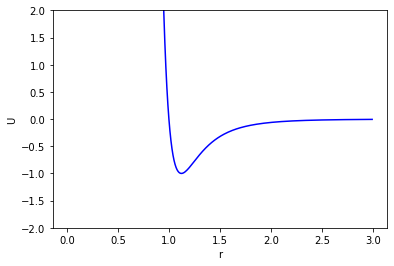

In [27]:
#Get pylab ready for plotting in this notebook - "magic" command specific for iPython notebooks
%pylab inline
#Import numpy
import numpy as np

#Generate array of distances to graph at
r = np.arange( 0,3, 0.01)

#Calculate U
U = 4.*(r**(-12.) - r**(-6.))

#Graph
plot( r, U, 'b-')
#Label x and y axes
xlabel('r')
ylabel('U')
#Adjust y limits not to be auto-scaled; since this goes to infinity at zero, the graph will not be useful unless we truncate
ylim(-2,2)


In [28]:
import md_sandbox
from md_sandbox import *

# If this error pops up on google collab:
# try:

#Let's define the variables we'll need
dt = 0.001
Cut = 2.5
L = 10 #Let's just put these in a fairly big box so we have room
M = 1 #Here this doesn't actually do anything, but I didn't remove it from the functions


#Choose N for number of particles
N = 2

#Allocate position array - initially just zeros
Pos = np.zeros((N,3), float)

#In this case, place two LJ particles at specified initial positions - chosen so they are relatively near each other
#If you had more than two particles you'd need to adjust this
Pos[0,:] = np.array([0,0,0])
Pos[1,:] = np.array([1.2,0,0])
#Might be worth experimenting to see what happens if we randomly place the particles instead


#Assign initial velocities - in this case I'll start off with them stationary and see what happens
Vel = np.array([[0,0,0],[0,0,0]], float)
#You could tweak the initial velocities to see what happens under different conditions

RuntimeError: ignored

ImportError: ignored

## Before we do any dynamics, notice that this is really a 1D system, so let's write a function to compute r, which we will store later

In [29]:
def get_r(Pos):
    """Calculate r, the distance between particles, for a position array containing just two particles. Return it."""
    
    #Get displacement
    dist = Pos[1,:] - Pos[0,:]
    #Calculate distance and return
    return np.sqrt( np.dot( dist, dist))

## OK, now let's start doing some dynamics

We're going to want to store the distance between the two particles as a function of time, so we can graph it. We also might want to look at the population of each distance as a function of time and see how that compares with the energy landscape. Though, right now that's a little premature. Let's just start off by taking a few timesteps and see how the distance changes. 

In [9]:
#Define storage for positions at each time so we can track them
max_steps = 5000 #Maximum number of steps we will take - so we know how many positions we might store
Pos_t = np.zeros(( N,3,max_steps), float)

#Store initial positions
Pos_t[:,:,0] = Pos

#Make up initial forces
Forces = np.zeros((N,3), float)

#Kick things off by calculating energy and forces
energy, Forces = calcenergyforces( Pos, M, L, Cut, Forces )

#Take a timestep
Pos, Vel, Accel, KEnergy, PEnergy = vvintegrate( Pos, Vel, Forces, M, L, Cut, dt )

#Store new positions
Pos_t[:,:,1] = Pos

#Print original and current distance
for i in range(0,2):
    print(get_r(Pos_t[:,:,i]))

NameError: ignored

## What should the long-time behavior of this system be?

Before going on to the step below, think for a minute about what motion these particles should exhibit on long timescales and what it would look like if you've graphed it.

Once you've done so, write a `for` loop to run over max_steps and at each step, update the energy and forces, take a timestep, and store the new positions.

In [ ]:
for i in range(max_steps):
   #Your code goes here
    energy, Forces = calcenergyforces( Pos, M, L, Cut, Forces )
    Pos, Vel, Accel, KEnergy, PEnergy = vvintegrate( Pos, Vel, Forces, M, L, Cut, dt )
    Pos_t[:,:,i] = Pos


## Once you've done that, use this code to graph r versus time for your particles

In [ ]:
#Find x axis (time values)
t = dt*np.arange(0,max_steps)
#Find y axis (r values)
r_vs_t = []
for i in range(max_steps):
    r=get_r(Pos_t[:,:,i])
    r_vs_t.append(r)

r_vs_t = np.array(r_vs_t)

    
#Plot
figure()
plot(t, r_vs_t)
    

## Additional exercises

Some things you might want to try on the above 1D system:
- Change the amount of time the data is graphed for; see if you can make it oscillate repeatedly
- Consider how you could adjust the total energy of the system
- What if you change the total energy (increasing it or reducing it). Can you make it look more like a harmonic oscillator? Less like a harmonic oscillator? Why or why not?
- Can you find solutions which are not oscillatory? How? 
- For the ambitious: Consider extending this example to three or more particles and graph just some of the distances involved. What kind of solutions can you find?

# Now let's do MD on a molecule!

So that was some very simple MD on a 1D Lennard-Jones system. Now let's head towards the opposite extreme and do our first molecular system.

Here, we'll draw on OpenMM, a molecular mechanics toolkit we'll see again later in the class, for running some simple energy minimizations and molecular dynamics. And we'll use the new `openforcefield` tools for assigning a force field for a molecule, because they make this very simple (and you have them already installed).

## First, we generate a molecule

In [ ]:
#@title
# What SMILES string for the guest? Should be isomeric SMILES
mol_smiles = 'OC(CC1CCCC1)=O'

# Import stuff
from openeye.oechem import *
import oenotebook as oenb
from openeye.oeomega import * # conformer generation
from openeye.oequacpac import * #for partial charge assignment

# Create empty OEMol
mol = OEMol()
# Convert SMILES
OESmilesToMol(mol, mol_smiles)
# Draw
oenb.draw_mol(mol)

## Now we generate a 3D structure of our compound and assign partial charges

In [ ]:
#initialize omega for conformer generation
omega = OEOmega()
omega.SetMaxConfs(100) #Generate up to 100 conformers since we'll use for docking
omega.SetIncludeInput(False)
omega.SetStrictStereo(True) #Refuse to generate conformers if stereochemistry not provided

#Initialize charge generation
chargeEngine = OEAM1BCCCharges()

# Set to use a simple neutral pH model 
OESetNeutralpHModel(mol)

# Generate conformers with Omega; keep only best conformer
status = omega(mol)
if not status:
    print("Error generating conformers for %s." % (guest_smiles))

# Assign AM1-BCC charges
OEAssignCharges(mol, chargeEngine)

# Write out PDB of molecule
ofile = oemolostream('mymolecule.pdb')
OEWriteMolecule(ofile, mol)
ofile.close()

## Now we apply a force field to assign parameters to the system

This uses the `openforcefield` toolkit and its `smirnoff99Frosst` forcefield (a new GAFF-like forcefield for small molecules).

In [ ]:
from openforcefield.typing.engines.smirnoff import *

ff = ForceField('forcefield/smirnoff99Frosst.offxml')
topology = generateTopologyFromOEMol(mol)
system = ff.createSystem(topology, [mol])

from openforcefield.utils import get_data_filename, extractPositionsFromOEMol, generateTopologyFromOEMol
positions = extractPositionsFromOEMol(mol)

## Next we'll start off by doing an energy minimization

We first prepare the system, but then the actual energy minimization is very simple. I believe OpenMM is using an L-BFGS minimizer.

In [ ]:
# Even though we're just going to minimize, we still have to set up an integrator, since a Simulation needs one
integrator = openmm.VerletIntegrator(2.0*unit.femtoseconds)
# Prep the Simulation using the parameterized system, the integrator, and the topology
simulation = app.Simulation(topology, system, integrator)
# Copy in the positions
simulation.context.setPositions( positions) 

# Get initial state and energy; print
state = simulation.context.getState(getEnergy = True)
energy = state.getPotentialEnergy() / unit.kilocalories_per_mole
print("Energy before minimization (kcal/mol): %.2g" % energy)

# Minimize, get final state and energy and print
simulation.minimizeEnergy()
state = simulation.context.getState(getEnergy=True, getPositions=True)
energy = state.getPotentialEnergy() / unit.kilocalories_per_mole
print("Energy after minimization (kcal/mol): %.2g" % energy)
newpositions = state.getPositions()

## Now we do some bookkeeping to run MD

Most of this is just setup, file bookkeeping, temperature selection, etc. The key part which actually runs it is the second-to-last block of code which says `simulation.step(1000)` which runs 1000 steps of dynamics. The timestep for this is set near the top, and is 2 femtoseconds per timestep, so the total time is 2000 fs, or 2 ps.

Simulation snapshots are stored to a NetCDF file for later visualization, every 100 frames (so we'll end up with 10 of them). You can adjust these settings if you like.

In [ ]:
# Set up NetCDF reporter for storing trajectory; prep for Langevin dynamics
from mdtraj.reporters import NetCDFReporter
integrator = openmm.LangevinIntegrator(300*unit.kelvin, 1./unit.picosecond, 2.*unit.femtoseconds)

# Prep Simulation
simulation = app.Simulation(topology, system, integrator)
# Copy in minimized positions
simulation.context.setPositions(newpositions)

# Initialize velocities to correct temperature
simulation.context.setVelocitiesToTemperature(300*unit.kelvin)
# Set up to write trajectory file to NetCDF file in data directory every 100 frames
netcdf_reporter = NetCDFReporter(os.path.join('.', 'trajectory.nc'), 100) #Store every 100 frames
# Initialize reporters, including a CSV file to store certain stats every 100 frames
simulation.reporters.append(netcdf_reporter)
simulation.reporters.append(app.StateDataReporter(os.path.join('.', 'data.csv'), 100, step=True, potentialEnergy=True, temperature=True, density=True))

# Run the simulation and print start info; store timing
print("Starting simulation")
start = time.clock()
simulation.step(1000) #1000 steps of dynamics
end = time.clock()

# Print elapsed time info, finalize trajectory file
print("Elapsed time %.2f seconds" % (end-start))
netcdf_reporter.close()
print("Done!")

## Now we can visualize the results with `nglview`

If you don't have `nglview`, you can also load the PDB file, `mymolecule.pdb`, with a standard viewer like VMD or Chimera, and then load the NetCDF trajectory file (`trajectory.nc`) in afterwards.

In [ ]:
# Load stored trajectory using MDTraj; the trajectory doesn't contain chemistry info so we also load a PDB
import mdtraj
import nglview
traj= mdtraj.load(os.path.join('.', 'trajectory.nc'), top=os.path.join('.', 'mymolecule.pdb'))

# View the trajectory
view = nglview.show_mdtraj(traj)
view

## Exercises

- Try your own molecule. What about one which has the potential for internal hydrogen bonding?
- Run the dynamics longer
- What is different if you lower the temperature? Raise the temperature? 